In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score


In [2]:
#Preprocess data
%run preprocessing.ipynb import preprocess, clean, remove_outliers, rescale_dataset, undersample_data, split_external_data

df=pd.read_csv("sbcdata.csv")
#Use df_uml for training the model and df_umg for validation
df_uml, df_umg = preprocess(df, save_csv=True)


Count of each target variable before preprop: Diagnosis
0.0    1776380
1.0     251395
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Length of X_df after scaling: 1916945
Count of each target variable after rescaling: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Count of each target variable before undersampling: Diagnosis
0.0    1673822
1.0     243123
Name: count, dtype: int64
Count of each target variable after undersampling: Diagnosis
0.0    243123
1.0    243123
Name: count, dtype: int64
Count of each target variable before preprop: Diagnosis
0.0    526943
1.0    128578
Name: count, dtype: int64
Count of each target variable after dropping na and duplicates: Diagnosis
0.0    513133
1.0    122511
Name: count, dtype: int64
Length of X_df after scaling: 635644
Count of each target variable after rescaling: Diagnosis
0.0    513133
1.0    122511
Name: count, d

In [3]:
#Check for undersampling in training dataset
print(f"UML Dataset - {df_uml['Diagnosis'].value_counts()}\n")

#Check for undersampling in validation dataset
print(f"UMG Dataset - {df_umg['Diagnosis'].value_counts()}\n")

UML Dataset - Diagnosis
0.0    243123
1.0    243123
Name: count, dtype: int64

UMG Dataset - Diagnosis
0.0    122511
1.0    122511
Name: count, dtype: int64



In [4]:
#Train Random Forest model with the uml dataset
#Target in y
y=df_uml['Diagnosis']
X=df_uml.drop(columns=['Diagnosis'])

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier(n_estimators = 200,
                                  random_state = 42, 
                                  n_jobs = -1,
                                  class_weight='balanced'
)
rf_model.fit(X_train, y_train)

#Save the model for reuse
import pickle
pickle.dump(rf_model, open("randomForest_model.pkl", "wb"))

In [5]:
#Test
print("---------Testing with the UML Dataset---------------")
y_predict=rf_model.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, y_predict):.3f}\n")
print(f"Classification report:\n {classification_report(y_test, y_predict)}")

---------Testing with the UML Dataset---------------
Accuracy score: 0.810

Classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.77      0.80     48699
         1.0       0.79      0.85      0.82     48551

    accuracy                           0.81     97250
   macro avg       0.81      0.81      0.81     97250
weighted avg       0.81      0.81      0.81     97250



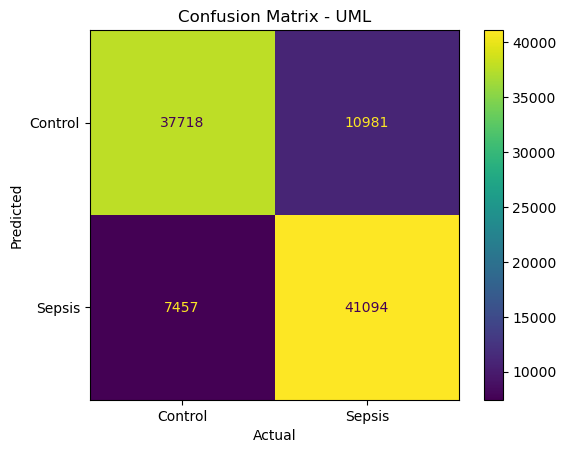

In [6]:
#Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ['Control','Sepsis']).plot()

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix - UML')
plt.show()

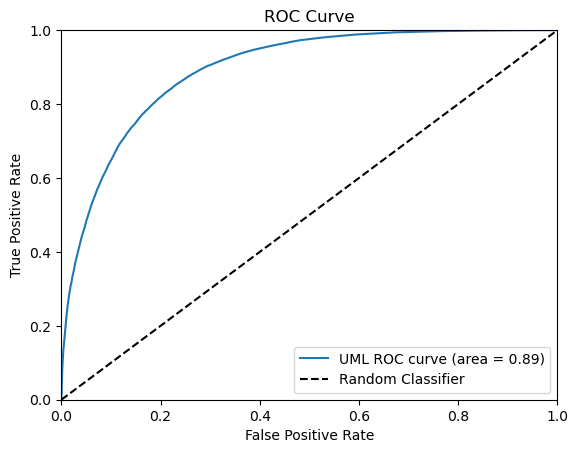

In [7]:
#ROC curve
# Generate predictions
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label = 1)
# Calculate the ROC AUC score 
roc_auc = roc_auc_score(y_test, y_pred_prob) 

# Plot the ROC curve 
plt.plot(fpr, tpr, label = 'UML ROC curve (area = %0.2f)' % roc_auc) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label = 'Random Classifier') 
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc = "lower right") 
plt.show()

Feature importances - UML:
             0
RBC  0.233251
HGB  0.227091
WBC  0.150356
PLT  0.149082
Age  0.113005
MCV  0.112160
Sex  0.015056



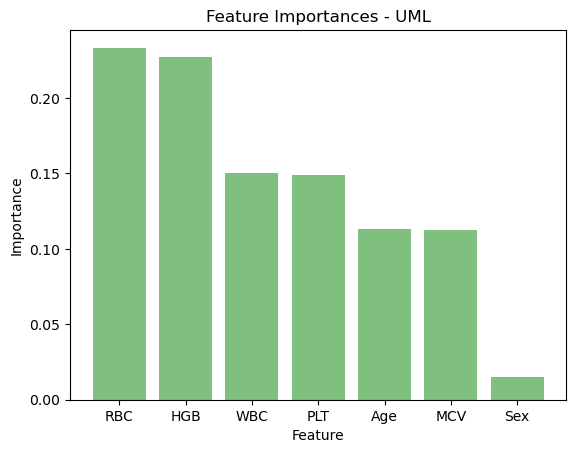

In [8]:
#Feature importance
features = pd.DataFrame(rf_model.feature_importances_, index = X.columns)
features = features.sort_values(by = 0, ascending = False)
print(f"Feature importances - UML:\n {features}\n")
plt.bar(features.index, features[0], color = 'green', alpha = 0.5)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances - UML')
plt.show()

In [9]:
#Validate using the UMG dataset
X_validation = df_umg.drop(columns='Diagnosis')
y_validation = df_umg['Diagnosis']
y_pred_valid = rf_model.predict(X_validation)
print("---------Validation with the UMG Dataset---------------")
print(f"Accuracy score: {accuracy_score(y_validation, y_pred_valid):.3f}\n")
print(f"Classification report:\n {classification_report(y_validation, y_pred_valid)}")

---------Validation with the UMG Dataset---------------
Accuracy score: 0.605

Classification report:
               precision    recall  f1-score   support

         0.0       0.79      0.28      0.42    122511
         1.0       0.56      0.93      0.70    122511

    accuracy                           0.60    245022
   macro avg       0.68      0.60      0.56    245022
weighted avg       0.68      0.60      0.56    245022



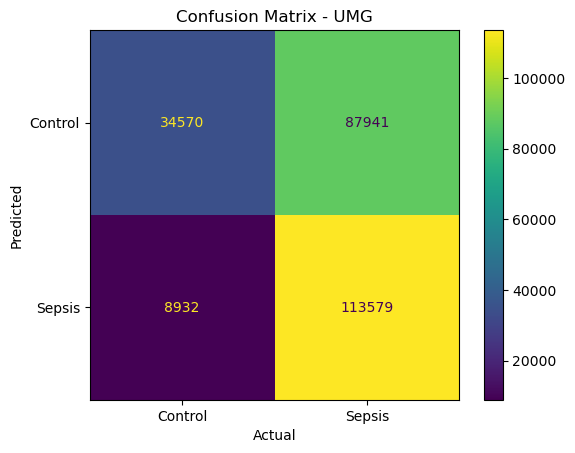

In [10]:
#Validation: calculate confusion matrix
conf_matrix_valid=confusion_matrix(y_validation, y_pred_valid)
ConfusionMatrixDisplay(confusion_matrix = conf_matrix_valid, display_labels = ['Control','Sepsis']).plot()

plt.ylabel('Predicted')
plt.title('Confusion Matrix - UMG')
plt.xlabel('Actual')
plt.show()

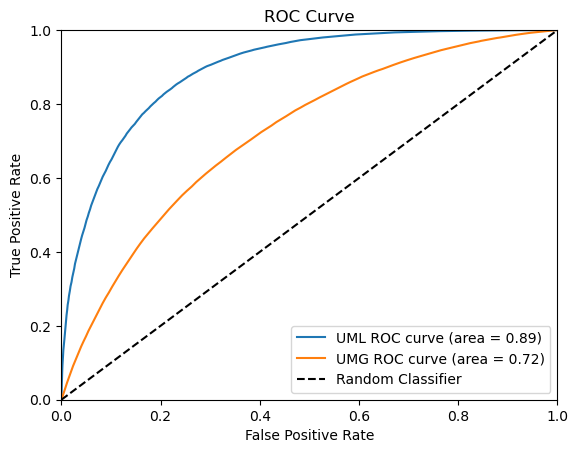

In [11]:
# Validation: ROC curve
# Generate predictions 
y_pred_valid_prob = rf_model.predict_proba(X_validation)[:, 1]
# Calculate the false positive rate (FPR) and true positive rate (TPR) 
fpr_v, tpr_v, thresholds_v = roc_curve(y_validation, y_pred_valid_prob, pos_label=1)
# Calculate the ROC AUC score 
roc_auc_v = roc_auc_score(y_validation, y_pred_valid_prob) 

# Plot the UML ROC curve 
plt.plot(fpr, tpr, label='UML ROC curve (area = %0.2f)' % roc_auc) 
# Plot the UMG ROC curve 
plt.plot(fpr_v, tpr_v, label='UMG ROC curve (area = %0.2f)' % roc_auc_v) 
# roc curve for tpr = fpr  
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier') 
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('ROC Curve') 
plt.legend(loc="lower right") 
plt.show()